In [3]:
from google.colab import drive
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

FASTA_FILE_PATH = "/content/drive/MyDrive/BioAi/neojunction_sequences_bedtools3.fasta" # Default path, user might need to adjust

In [2]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.4 MB/s eta 0:00:00


In [4]:
def mount_drive():
    try:
        drive.mount("/content/drive")
        print("Google Drive mounted successfully.")
    except Exception as e:
        print(f"Error mounting Google Drive: {e}")
        print("Please ensure you have authorized Google Drive access.")
        return False
    return True

def get_sequence_lengths(fasta_file):
    """Parses a FASTA file and returns a list of sequence lengths."""
    lengths = []
    print(f"Processing FASTA file: {fasta_file}...")
    try:
        with open(fasta_file, "r") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                lengths.append(len(record.seq))
        if not lengths:
            print("No sequences found in the FASTA file or file is empty.")
        else:
            print(f"Processed {len(lengths)} sequences.")
    except FileNotFoundError:
        print(f"Error: File not found at {fasta_file}. Please check the path.")
        return None
    except Exception as e:
        print(f"An error occurred while parsing the FASTA file: {e}")
        return None
    return lengths

def calculate_summary_statistics(lengths):
    """Calculates summary statistics for a list of lengths."""
    if not lengths:
        print("No lengths provided to calculate statistics.")
        return None

    stats = {
        "count": len(lengths),
        "min_length": np.min(lengths),
        "max_length": np.max(lengths),
        "mean_length": np.mean(lengths),
        "median_length": np.median(lengths),
        "std_dev_length": np.std(lengths)
    }
    print("\nSummary Statistics for Sequence Lengths:")
    for key, value in stats.items():
        print(f"{key.replace('_', ' ').capitalize()}: {value:.2f}" if isinstance(value, float) else f"{key.replace('_', ' ').capitalize()}: {value}")
    return stats

def plot_length_distribution(lengths, file_basename="sequence_lengths"):
    """Generates and saves plots for sequence length distribution."""
    if not lengths:
        print("No lengths provided to plot distribution.")
        return

    print("\nGenerating general distribution plots...")
    plt.style.use('seaborn-v0_8-whitegrid')

    # 1. Histogram
    plt.figure(figsize=(12, 6))
    sns.histplot(lengths, kde=True, bins=50)
    plt.title("Overall Sequence Length Distribution (Histogram)")
    plt.xlabel("Sequence Length (bp)")
    plt.ylabel("Frequency")
    plt.grid(True)
    histogram_path = f"{file_basename}_overall_histogram.png"
    plt.savefig(histogram_path)
    plt.show()
    print(f"Overall histogram saved to {histogram_path}")

    # 2. Box Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=lengths)
    plt.title("Overall Sequence Length Distribution (Box Plot)")
    plt.xlabel("Sequence Length (bp)")
    plt.grid(True)
    boxplot_path = f"{file_basename}_overall_boxplot.png"
    plt.savefig(boxplot_path)
    plt.show()
    print(f"Overall box plot saved to {boxplot_path}")

    if lengths and np.max(lengths) > (np.median(lengths) + 3 * np.std(lengths)):
        print("\nNote: The overall box plot might indicate the presence of outliers (very long sequences).")

def analyze_sequences_in_windows(all_sequence_lengths, window_size, max_length_cutoff, plot_file_prefix="windowed_counts"):
    """Analyzes and plots sequence counts within defined length windows up to a max_length_cutoff."""
    if not all_sequence_lengths:
        print(f"No sequence lengths provided for window analysis (window: {window_size}bp, max: {max_length_cutoff}bp).")
        return

    # Filter sequences by max_length_cutoff
    lengths_in_range = [l for l in all_sequence_lengths if l <= max_length_cutoff and l > 0]
    if not lengths_in_range:
        print(f"No sequences found within the range 0-{max_length_cutoff}bp for window size {window_size}bp.")
        return

    print(f"\n--- Analyzing sequences up to {max_length_cutoff}bp with window size {window_size}bp ---")
    print(f"Found {len(lengths_in_range)} sequences within this range.")

    # Define bins
    bins = np.arange(0, max_length_cutoff + window_size, window_size)
    if bins[-1] > max_length_cutoff and len(bins) > 1: # Adjust last bin if it exceeds max_length_cutoff significantly and is not the only bin
        if bins[-2] < max_length_cutoff:
             bins[-1] = max_length_cutoff
        else: # if the second to last bin is already at or beyond max_length_cutoff, just use up to second to last
             bins = bins[:-1]
    if len(bins) == 1 and bins[0] == 0 : # if only one bin [0] and max_length_cutoff > 0, make it [0, max_length_cutoff]
        bins = np.array([0, max_length_cutoff])
    elif len(bins) == 0 and max_length_cutoff > 0:
        bins = np.array([0, max_length_cutoff])
    elif max_length_cutoff > 0 and bins[-1] < max_length_cutoff and window_size < max_length_cutoff : # Ensure the last bin reaches max_length_cutoff if not already covered
        bins = np.append(bins, max_length_cutoff)
        bins = np.unique(bins) # remove duplicates if any

    # Ensure bins are at least two elements for pd.cut if there are lengths
    if len(bins) < 2 and lengths_in_range:
        if max_length_cutoff > 0:
            bins = np.array([0, max_length_cutoff])
        else: # Should not happen if lengths_in_range is not empty
            print(f"Cannot create meaningful bins for max_length_cutoff {max_length_cutoff} and window_size {window_size}.")
            return

    # Count sequences in each bin
    counts, _ = np.histogram(lengths_in_range, bins=bins)

    # Create labels for the bins
    bin_labels = []
    for i in range(len(bins) - 1):
        start = bins[i]
        end = bins[i+1]
        # Adjust label for the first bin to be 1-end if start is 0
        if start == 0:
            label = f"1-{end}"
        else:
            label = f"{start+1}-{end}"
        bin_labels.append(label)

    print("\nSequence Counts per Window:")
    for i, count in enumerate(counts):
        print(f"Window {bin_labels[i]} bp: {count} sequences")

    # Plotting
    plt.figure(figsize=(12, 7))
    # Check if bin_labels and counts have content
    if not bin_labels or len(counts) == 0:
        print("No data to plot for windowed counts.")
        plt.title(f"No sequences to plot for {window_size}bp windows up to {max_length_cutoff}bp")
        plt.xlabel("Sequence Length Window (bp)")
        plt.ylabel("Number of Sequences")
    else:
        sns.barplot(x=bin_labels, y=counts, palette="viridis")
        plt.title(f"Sequence Counts in {window_size}bp Windows (up to {max_length_cutoff}bp)")
        plt.xlabel("Sequence Length Window (bp)")
        plt.ylabel("Number of Sequences")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout() # Adjust layout to prevent labels from overlapping

    plot_filename = f"{plot_file_prefix}_ws{window_size}_max{max_length_cutoff}.png"
    plt.savefig(plot_filename)
    plt.show()
    print(f"Windowed counts plot saved to {plot_filename}")

Mounted at /content/drive
Google Drive mounted successfully.
Processing FASTA file: /content/drive/MyDrive/BioAi/neojunction_sequences_bedtools3.fasta...
Processed 241254 sequences.

Summary Statistics for Sequence Lengths:
Count: 241254
Min length: 22
Max length: 498248
Mean length: 11951.38
Median length: 2750.00
Std dev length: 28283.41

Generating general distribution plots...


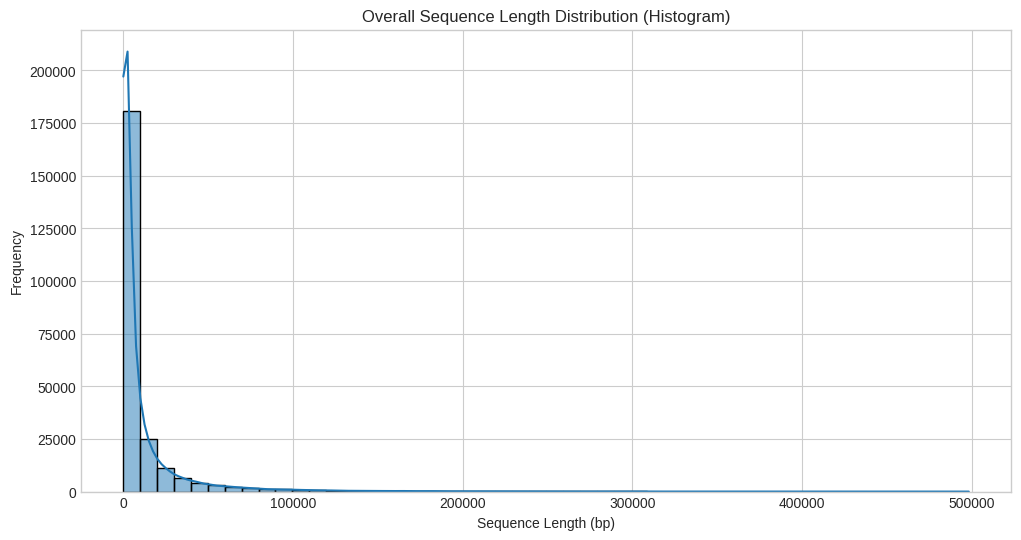

Overall histogram saved to sequence_lengths_overall_histogram.png


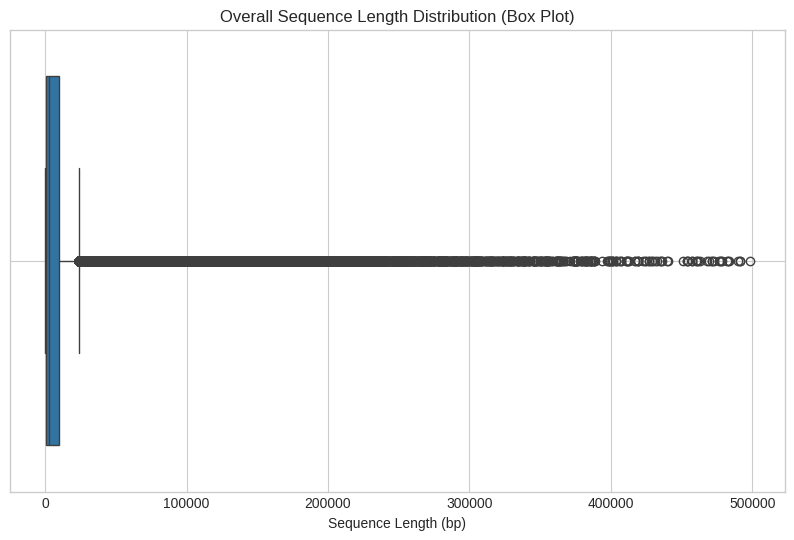

Overall box plot saved to sequence_lengths_overall_boxplot.png

Note: The overall box plot might indicate the presence of outliers (very long sequences).


--- Starting Windowed Sequence Count Analysis ---

--- Analyzing sequences up to 10000bp with window size 500bp ---
Found 180741 sequences within this range.

Sequence Counts per Window:
Window 1-500 bp: 46944 sequences
Window 501-1000 bp: 26462 sequences
Window 1001-1500 bp: 18020 sequences
Window 1501-2000 bp: 13617 sequences
Window 2001-2500 bp: 11013 sequences
Window 2501-3000 bp: 8853 sequences
Window 3001-3500 bp: 7687 sequences
Window 3501-4000 bp: 6476 sequences
Window 4001-4500 bp: 5647 sequences
Window 4501-5000 bp: 5111 sequences
Window 5001-5500 bp: 4498 sequences
Window 5501-6000 bp: 4024 sequences
Window 6001-6500 bp: 3709 sequences
Window 6501-7000 bp: 3303 sequences
Window 7001-7500 bp: 3157 sequences
Window 7501-8000 bp: 2871 sequences
Window 8001-8500 bp: 2535 sequences
Window 8501-9000 bp: 2510 sequences
Window 90

<ipython-input-4-71773101228a>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_labels, y=counts, palette="viridis")


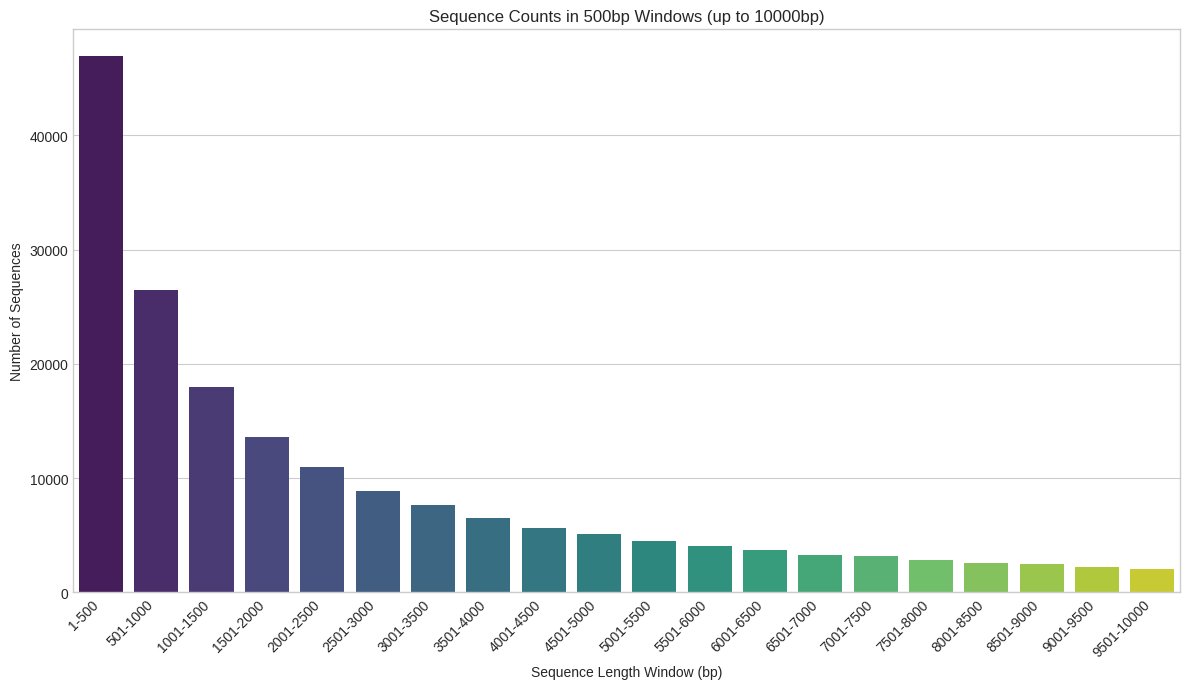

Windowed counts plot saved to sequence_lengths_windowed_ws500_max10000.png

--- Analyzing sequences up to 50000bp with window size 500bp ---
Found 227676 sequences within this range.

Sequence Counts per Window:
Window 1-500 bp: 46944 sequences
Window 501-1000 bp: 26462 sequences
Window 1001-1500 bp: 18020 sequences
Window 1501-2000 bp: 13617 sequences
Window 2001-2500 bp: 11013 sequences
Window 2501-3000 bp: 8853 sequences
Window 3001-3500 bp: 7687 sequences
Window 3501-4000 bp: 6476 sequences
Window 4001-4500 bp: 5647 sequences
Window 4501-5000 bp: 5111 sequences
Window 5001-5500 bp: 4498 sequences
Window 5501-6000 bp: 4024 sequences
Window 6001-6500 bp: 3709 sequences
Window 6501-7000 bp: 3303 sequences
Window 7001-7500 bp: 3157 sequences
Window 7501-8000 bp: 2871 sequences
Window 8001-8500 bp: 2535 sequences
Window 8501-9000 bp: 2510 sequences
Window 9001-9500 bp: 2244 sequences
Window 9501-10000 bp: 2058 sequences
Window 10001-10500 bp: 2048 sequences
Window 10501-11000 bp: 1838 s

<ipython-input-4-71773101228a>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_labels, y=counts, palette="viridis")


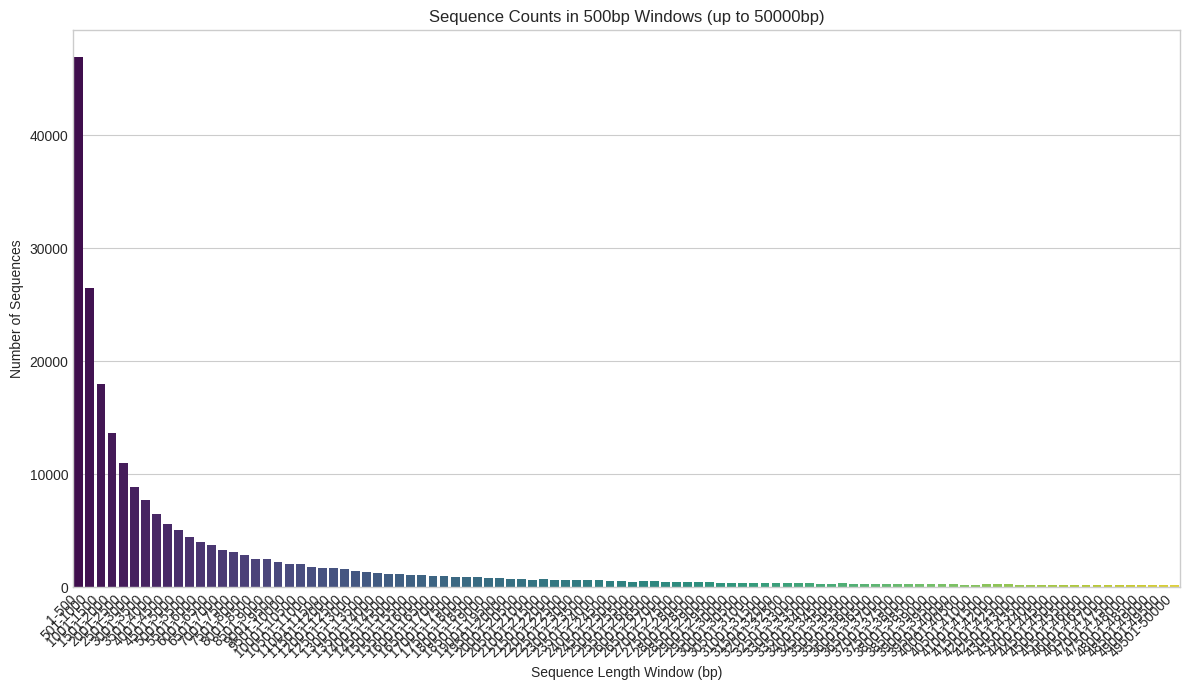

Windowed counts plot saved to sequence_lengths_windowed_ws500_max50000.png

--- Analyzing sequences up to 100000bp with window size 500bp ---
Found 236576 sequences within this range.

Sequence Counts per Window:
Window 1-500 bp: 46944 sequences
Window 501-1000 bp: 26462 sequences
Window 1001-1500 bp: 18020 sequences
Window 1501-2000 bp: 13617 sequences
Window 2001-2500 bp: 11013 sequences
Window 2501-3000 bp: 8853 sequences
Window 3001-3500 bp: 7687 sequences
Window 3501-4000 bp: 6476 sequences
Window 4001-4500 bp: 5647 sequences
Window 4501-5000 bp: 5111 sequences
Window 5001-5500 bp: 4498 sequences
Window 5501-6000 bp: 4024 sequences
Window 6001-6500 bp: 3709 sequences
Window 6501-7000 bp: 3303 sequences
Window 7001-7500 bp: 3157 sequences
Window 7501-8000 bp: 2871 sequences
Window 8001-8500 bp: 2535 sequences
Window 8501-9000 bp: 2510 sequences
Window 9001-9500 bp: 2244 sequences
Window 9501-10000 bp: 2058 sequences
Window 10001-10500 bp: 2048 sequences
Window 10501-11000 bp: 1838 

<ipython-input-4-71773101228a>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_labels, y=counts, palette="viridis")


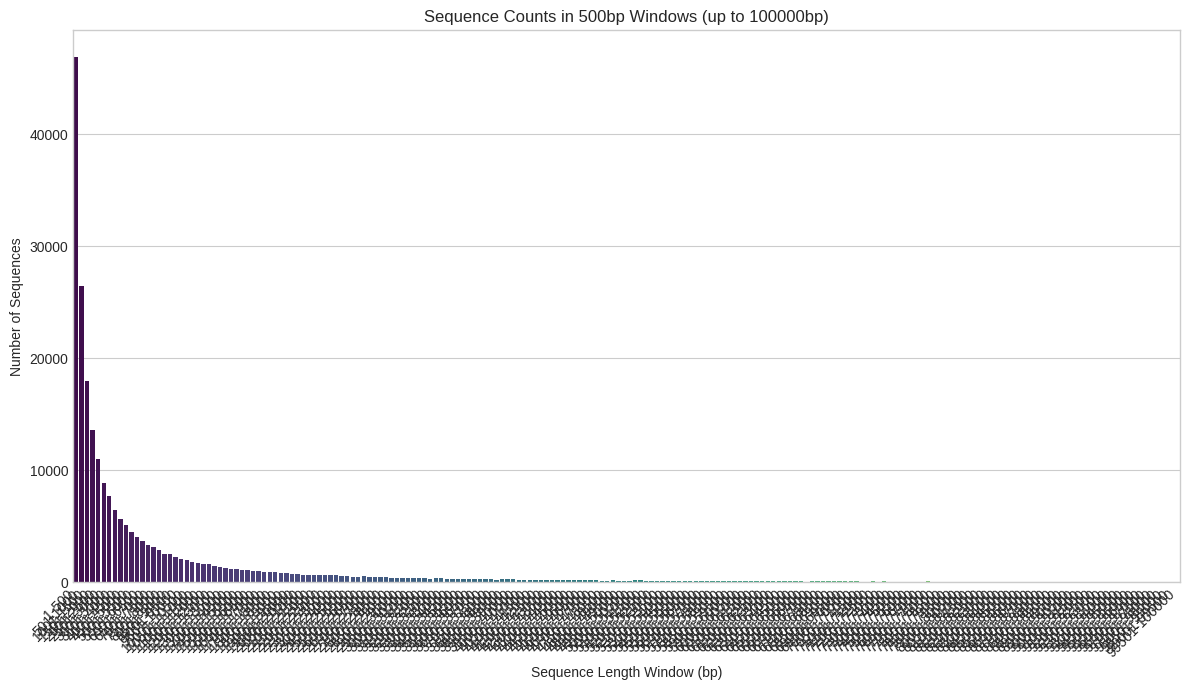

Windowed counts plot saved to sequence_lengths_windowed_ws500_max100000.png

--- Analyzing sequences up to 10000bp with window size 1000bp ---
Found 180741 sequences within this range.

Sequence Counts per Window:
Window 1-1000 bp: 73406 sequences
Window 1001-2000 bp: 31637 sequences
Window 2001-3000 bp: 19866 sequences
Window 3001-4000 bp: 14163 sequences
Window 4001-5000 bp: 10758 sequences
Window 5001-6000 bp: 8522 sequences
Window 6001-7000 bp: 7012 sequences
Window 7001-8000 bp: 6028 sequences
Window 8001-9000 bp: 5045 sequences
Window 9001-10000 bp: 4304 sequences


<ipython-input-4-71773101228a>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_labels, y=counts, palette="viridis")


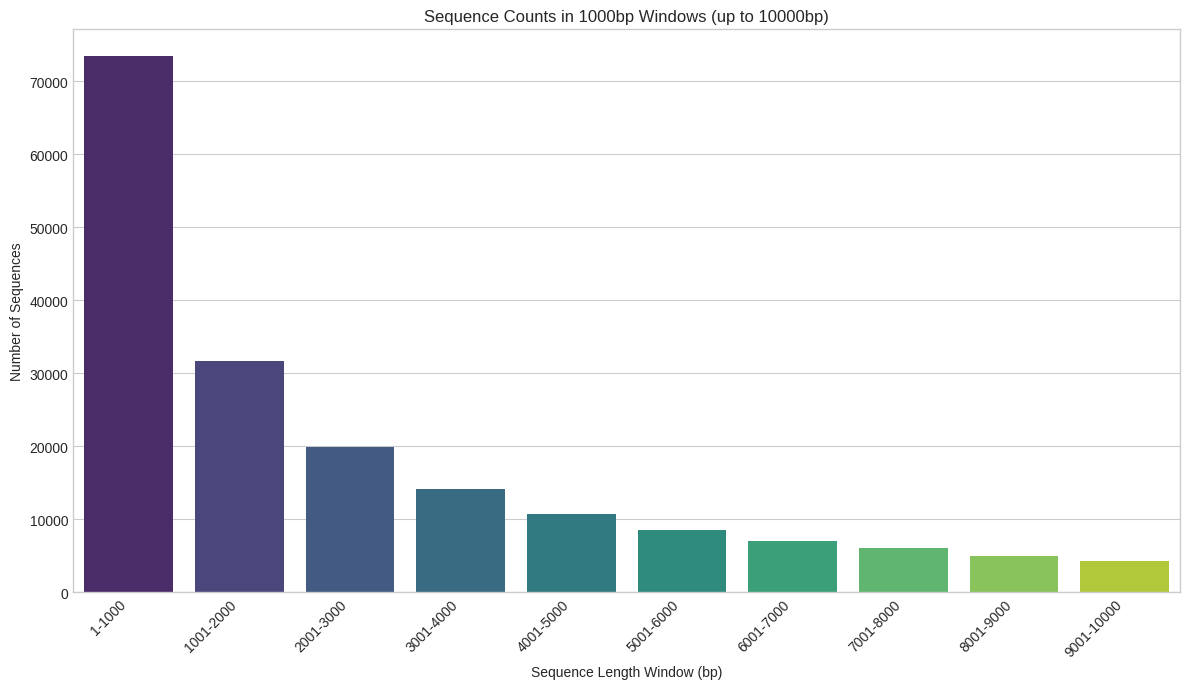

Windowed counts plot saved to sequence_lengths_windowed_ws1000_max10000.png

--- Analyzing sequences up to 50000bp with window size 1000bp ---
Found 227676 sequences within this range.

Sequence Counts per Window:
Window 1-1000 bp: 73406 sequences
Window 1001-2000 bp: 31637 sequences
Window 2001-3000 bp: 19866 sequences
Window 3001-4000 bp: 14163 sequences
Window 4001-5000 bp: 10758 sequences
Window 5001-6000 bp: 8522 sequences
Window 6001-7000 bp: 7012 sequences
Window 7001-8000 bp: 6028 sequences
Window 8001-9000 bp: 5045 sequences
Window 9001-10000 bp: 4302 sequences
Window 10001-11000 bp: 3886 sequences
Window 11001-12000 bp: 3425 sequences
Window 12001-13000 bp: 3102 sequences
Window 13001-14000 bp: 2693 sequences
Window 14001-15000 bp: 2372 sequences
Window 15001-16000 bp: 2221 sequences
Window 16001-17000 bp: 2036 sequences
Window 17001-18000 bp: 1867 sequences
Window 18001-19000 bp: 1742 sequences
Window 19001-20000 bp: 1618 sequences
Window 20001-21000 bp: 1417 sequences
Windo

<ipython-input-4-71773101228a>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_labels, y=counts, palette="viridis")


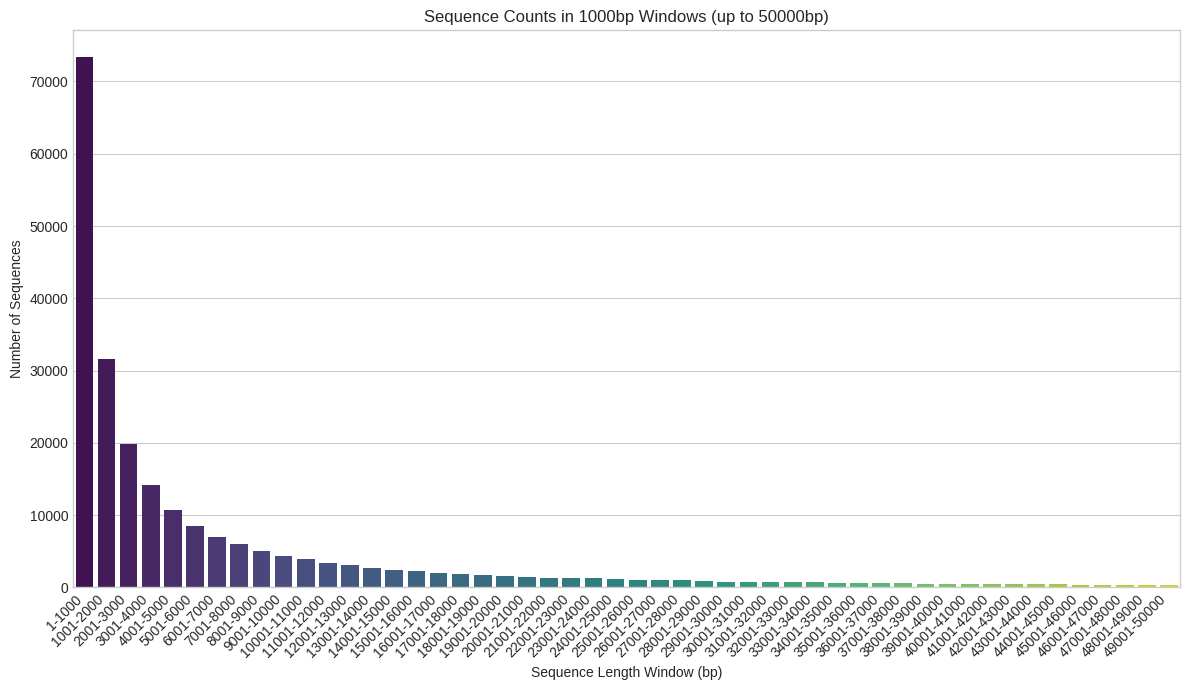

Windowed counts plot saved to sequence_lengths_windowed_ws1000_max50000.png

--- Analyzing sequences up to 100000bp with window size 1000bp ---
Found 236576 sequences within this range.

Sequence Counts per Window:
Window 1-1000 bp: 73406 sequences
Window 1001-2000 bp: 31637 sequences
Window 2001-3000 bp: 19866 sequences
Window 3001-4000 bp: 14163 sequences
Window 4001-5000 bp: 10758 sequences
Window 5001-6000 bp: 8522 sequences
Window 6001-7000 bp: 7012 sequences
Window 7001-8000 bp: 6028 sequences
Window 8001-9000 bp: 5045 sequences
Window 9001-10000 bp: 4302 sequences
Window 10001-11000 bp: 3886 sequences
Window 11001-12000 bp: 3425 sequences
Window 12001-13000 bp: 3102 sequences
Window 13001-14000 bp: 2693 sequences
Window 14001-15000 bp: 2372 sequences
Window 15001-16000 bp: 2221 sequences
Window 16001-17000 bp: 2036 sequences
Window 17001-18000 bp: 1867 sequences
Window 18001-19000 bp: 1742 sequences
Window 19001-20000 bp: 1618 sequences
Window 20001-21000 bp: 1417 sequences
Wind

<ipython-input-4-71773101228a>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_labels, y=counts, palette="viridis")


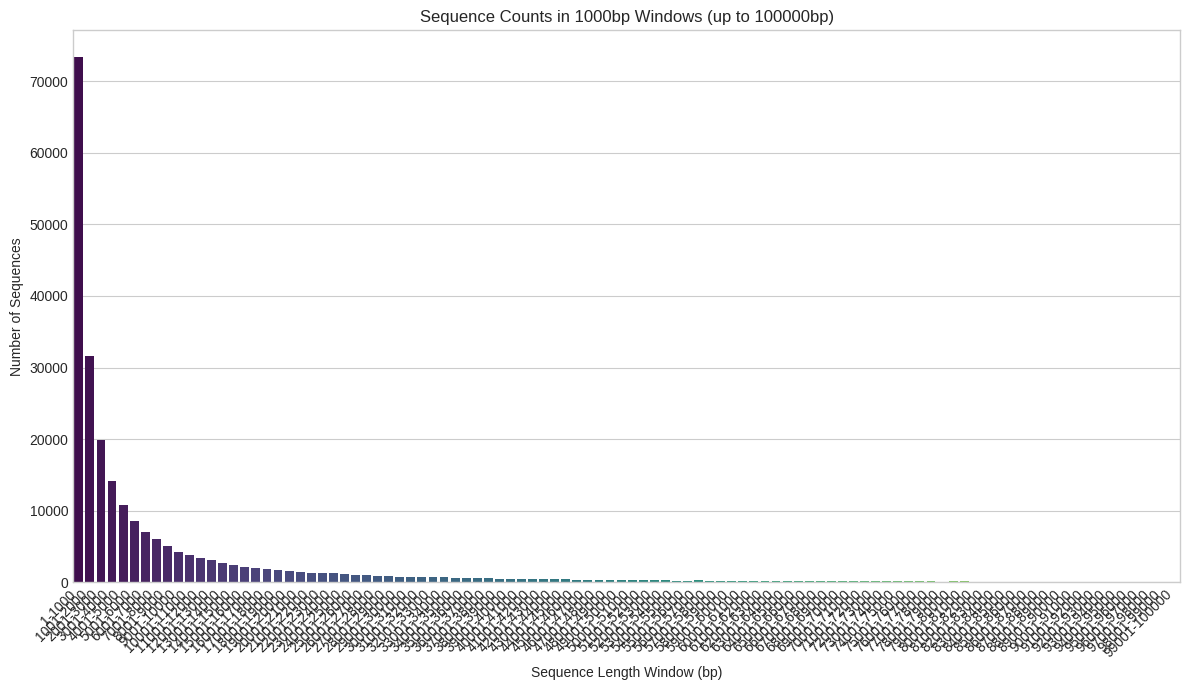

Windowed counts plot saved to sequence_lengths_windowed_ws1000_max100000.png

--- Analyzing sequences up to 10000bp with window size 2000bp ---
Found 180741 sequences within this range.

Sequence Counts per Window:
Window 1-2000 bp: 105043 sequences
Window 2001-4000 bp: 34029 sequences
Window 4001-6000 bp: 19280 sequences
Window 6001-8000 bp: 13040 sequences
Window 8001-10000 bp: 9349 sequences


<ipython-input-4-71773101228a>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_labels, y=counts, palette="viridis")


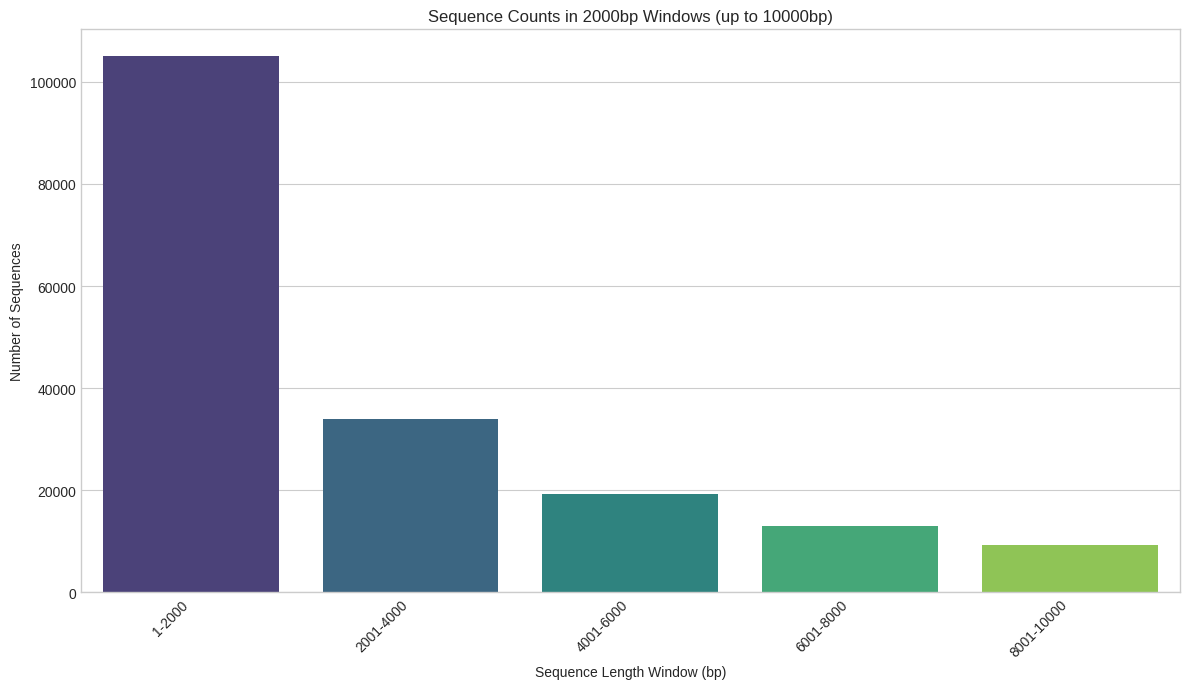

Windowed counts plot saved to sequence_lengths_windowed_ws2000_max10000.png

--- Analyzing sequences up to 50000bp with window size 2000bp ---
Found 227676 sequences within this range.

Sequence Counts per Window:
Window 1-2000 bp: 105043 sequences
Window 2001-4000 bp: 34029 sequences
Window 4001-6000 bp: 19280 sequences
Window 6001-8000 bp: 13040 sequences
Window 8001-10000 bp: 9347 sequences
Window 10001-12000 bp: 7311 sequences
Window 12001-14000 bp: 5795 sequences
Window 14001-16000 bp: 4593 sequences
Window 16001-18000 bp: 3903 sequences
Window 18001-20000 bp: 3360 sequences
Window 20001-22000 bp: 2765 sequences
Window 22001-24000 bp: 2550 sequences
Window 24001-26000 bp: 2194 sequences
Window 26001-28000 bp: 1982 sequences
Window 28001-30000 bp: 1704 sequences
Window 30001-32000 bp: 1504 sequences
Window 32001-34000 bp: 1467 sequences
Window 34001-36000 bp: 1313 sequences
Window 36001-38000 bp: 1154 sequences
Window 38001-40000 bp: 1070 sequences
Window 40001-42000 bp: 996 sequen

<ipython-input-4-71773101228a>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_labels, y=counts, palette="viridis")


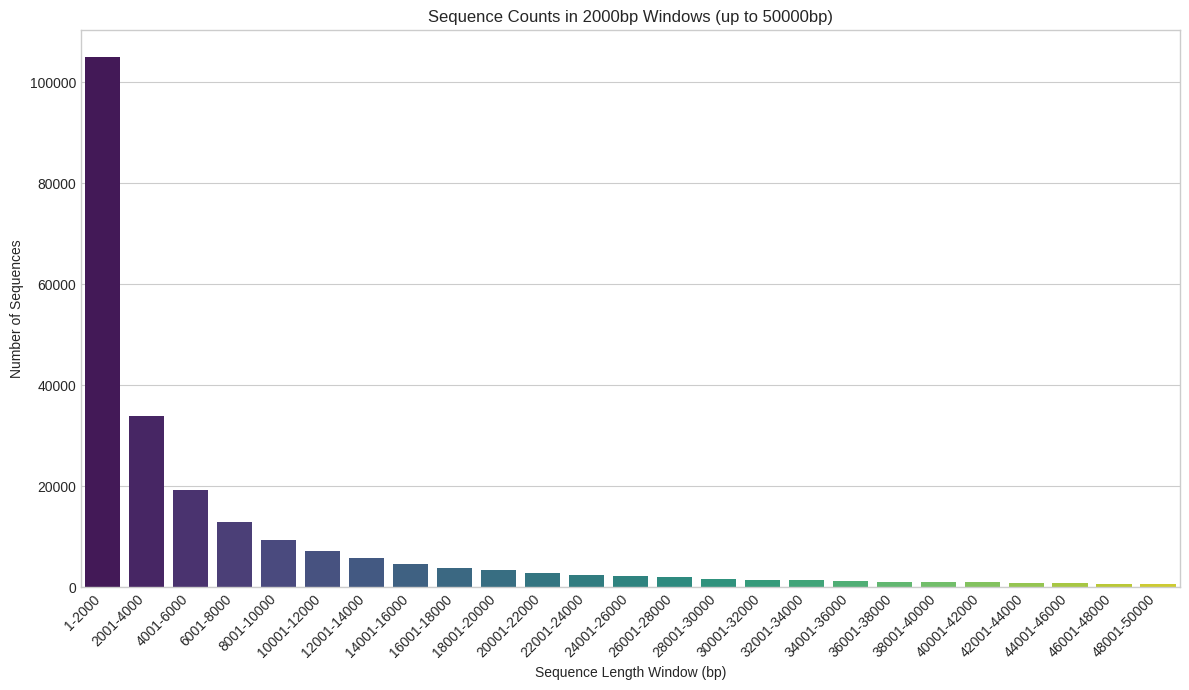

Windowed counts plot saved to sequence_lengths_windowed_ws2000_max50000.png

--- Analyzing sequences up to 100000bp with window size 2000bp ---
Found 236576 sequences within this range.

Sequence Counts per Window:
Window 1-2000 bp: 105043 sequences
Window 2001-4000 bp: 34029 sequences
Window 4001-6000 bp: 19280 sequences
Window 6001-8000 bp: 13040 sequences
Window 8001-10000 bp: 9347 sequences
Window 10001-12000 bp: 7311 sequences
Window 12001-14000 bp: 5795 sequences
Window 14001-16000 bp: 4593 sequences
Window 16001-18000 bp: 3903 sequences
Window 18001-20000 bp: 3360 sequences
Window 20001-22000 bp: 2765 sequences
Window 22001-24000 bp: 2550 sequences
Window 24001-26000 bp: 2194 sequences
Window 26001-28000 bp: 1982 sequences
Window 28001-30000 bp: 1704 sequences
Window 30001-32000 bp: 1504 sequences
Window 32001-34000 bp: 1467 sequences
Window 34001-36000 bp: 1313 sequences
Window 36001-38000 bp: 1154 sequences
Window 38001-40000 bp: 1070 sequences
Window 40001-42000 bp: 996 seque

<ipython-input-4-71773101228a>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_labels, y=counts, palette="viridis")


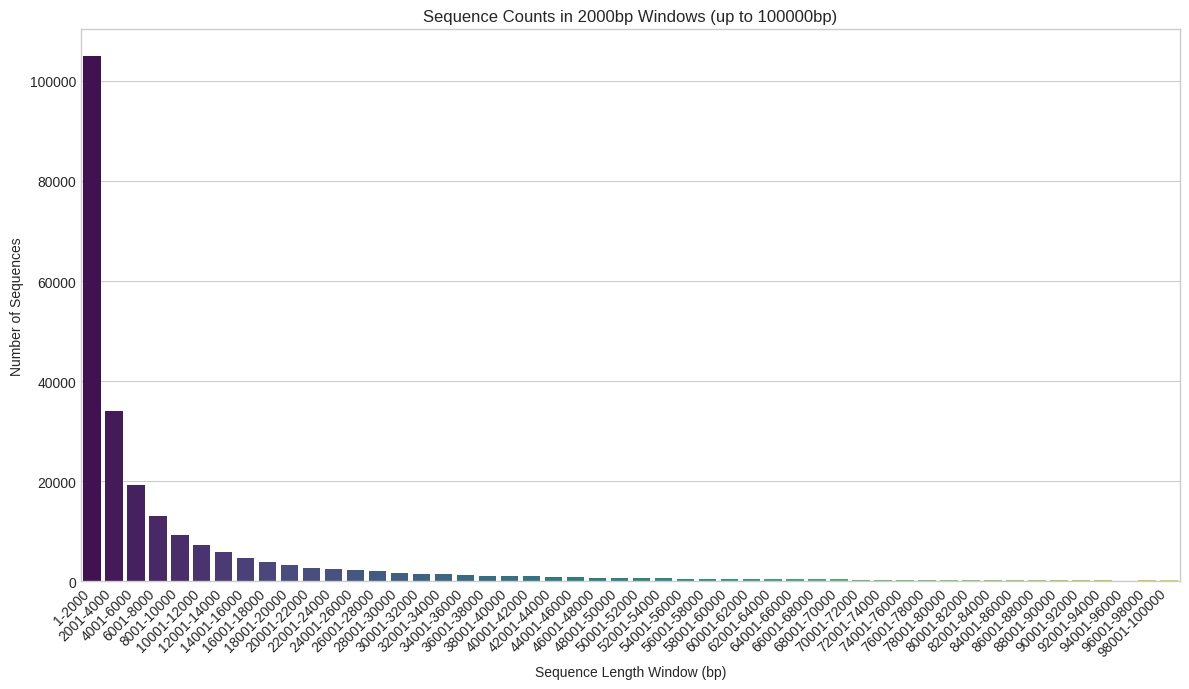

Windowed counts plot saved to sequence_lengths_windowed_ws2000_max100000.png


All analyses complete. Review the plots and statistics above.
Plots have been saved as .png files in your Colab environment.


In [5]:
if mount_drive():
    # Get sequence lengths
    all_sequence_lengths = get_sequence_lengths(FASTA_FILE_PATH)

    if all_sequence_lengths:
        # Calculate and print overall summary statistics
        summary_stats = calculate_summary_statistics(all_sequence_lengths)

        # Plot overall length distribution
        plot_length_distribution(all_sequence_lengths)

        print("\n\n--- Starting Windowed Sequence Count Analysis ---")
        # Define window sizes and max lengths for the new analysis
        window_sizes_to_analyze = [500, 1000, 2000]
        max_lengths_to_analyze = [10000, 50000, 100000]

        for ws in window_sizes_to_analyze:
            for ml in max_lengths_to_analyze:
                analyze_sequences_in_windows(all_sequence_lengths, ws, ml, plot_file_prefix="sequence_lengths_windowed")

        print("\n\nAll analyses complete. Review the plots and statistics above.")
        print(f"Plots have been saved as .png files in your Colab environment.")
    else:
        print("\nAnalysis could not be completed. Please check the file path and ensure the FASTA file is valid and accessible.")
else:
    print("\nGoogle Drive not mounted. Please mount Google Drive and try again.")